# Forecasting orthobullets.com Website Traffic Using Facebook’s Prophet Library

## Starting the Analysis
For this analysis, I will be using a spreadsheet of the actual web traffic volume from Orthobullets starting in July 2013 and going through July 2017. The data is downloaded from Google analytics and looks like this:




<image src="obtraff.png">
![alt text](obtraff.png "Traffic")

import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
plt.style.use('ggplot')

data_file = "OBtraffic3.csv"
data = pd.read_csv(data_file)
data.head()


Make sure "Day Index" column is of type datetime

In [2]:
data.dtypes

Day Index    object
Sessions      int64
dtype: object

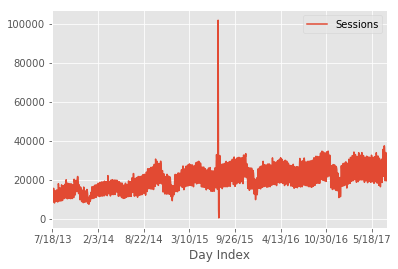

In [3]:
data.set_index("Day Index").plot()

The basic plot is interesting but, like most time series data, it is difficult to get much out of this without doing further analysis. Additionally, if you wanted to add a predicted trend-line, it is a non-trivial task with stock pandas.

Before going further, I do want to address the outlier in the August 2015 timeframe, Jimmy Fallon covered an orthopedic injury that sent hordes of viewers and irregular traffic to Orthobullets.

We're not particularly interested in this irregular event when it comes ot forecasting the future.

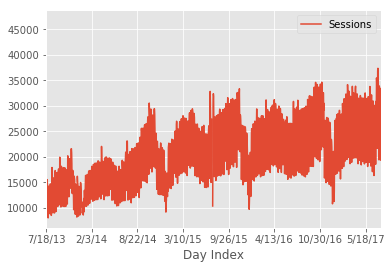

In [4]:
data.loc[(data['Sessions'] > 75000), 'Sessions'] = np.nan
data.loc[(data['Sessions'] < 8000), 'Sessions'] = np.nan
data.set_index('Day Index').plot();

This gives us a pretty good idea of our typical traffic patterns and the growth trendline. One more preprocessing step that would be helpful is a log transformation because what we care about are relative changes, not abolute changes, in website traffic. 

"logging converts multiplicative relationships to additive relationships, and by the same token it converts exponential (compound growth) trends to linear trends. By taking logarithms of variables which are multiplicatively related and/or growing exponentially over time, we can often explain their behavior with linear models."

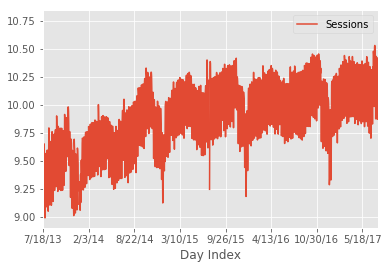

In [5]:
data['Sessions'] = np.log(data['Sessions'])
data.set_index('Day Index').plot();

The data set is almost ready to make a prediction. The final step is to rename the columns to ds and y in order to comply with the prophet API.

In [6]:
data.columns = ["ds", "y"]
data.head()

,ds,y
0,7/18/13,9.500993
1,7/19/13,9.325453
2,7/20/13,9.047351
3,7/21/13,9.310909
4,7/22/13,9.578104


Now that the data is cleaned and labeled correctly, let’s see what prophet can do with it.

## Making a Prediction

The prophet API is similar to scikit-learn. The general flow is to fit the data then predict the future time series. In addition, prophet supports some nice plotting features using plot and plot_components .

Create the first model (m1) and fit the data to our dataframe:

In [7]:
m1 = Prophet()
m1.fit(data)

In order to tell prophet how far to predict in the future, use make_future_dataframe. In this example, we will predict out 1 year (365 days).

In [8]:
future1 = m1.make_future_dataframe(periods=365)

Then make the forecast:

In [9]:
forecast1 = m1.predict(future1)

The forecast1 is just a pandas dataframe with a several columns of data. The predicted value is called yhat and the range is defined by yhat_lower and yhat_upper . To see the last 5 predicted values:

In [10]:
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1828,2018-07-20,10.377023,10.186041,10.555089
1829,2018-07-21,10.133914,9.945185,10.317058
1830,2018-07-22,10.331768,10.154413,10.504403
1831,2018-07-23,10.629522,10.436447,10.802055
1832,2018-07-24,10.646083,10.456693,10.816048


To convert back to the numerical values representing sessions, use np.exp

In [11]:
forecast = np.exp(forecast1[['yhat', 'yhat_lower', 'yhat_upper']].tail())

To make this look nice and impress management, plot the data:

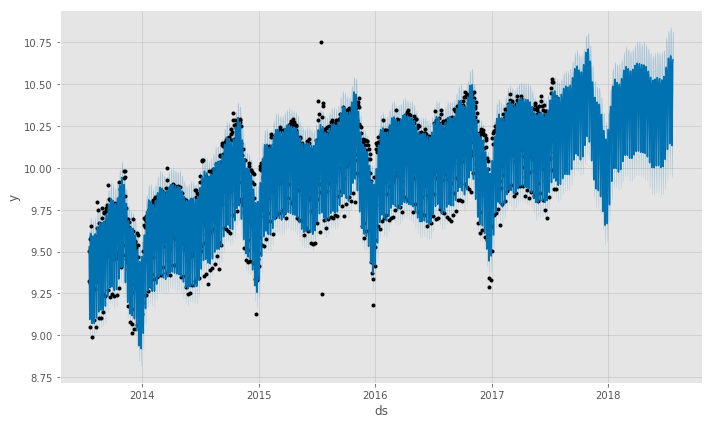

In [12]:
m1.plot(forecast1);

Very cool. The other useful feature is the ability to plot the various components:

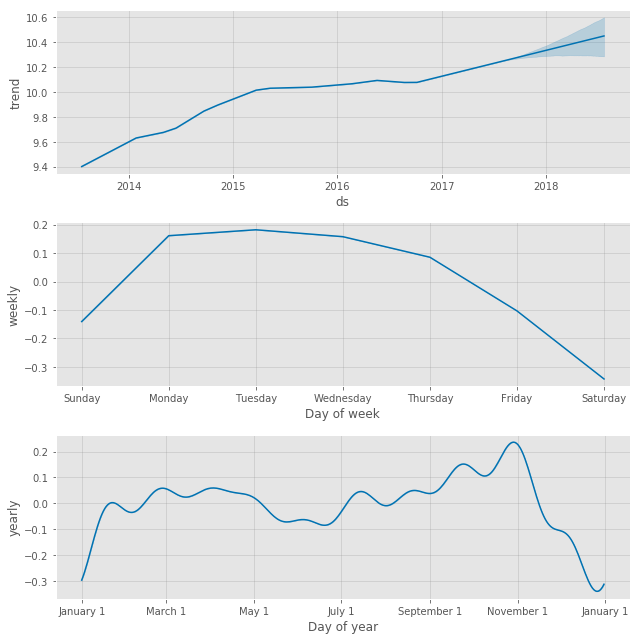

In [13]:
m1.plot_components(forecast1);

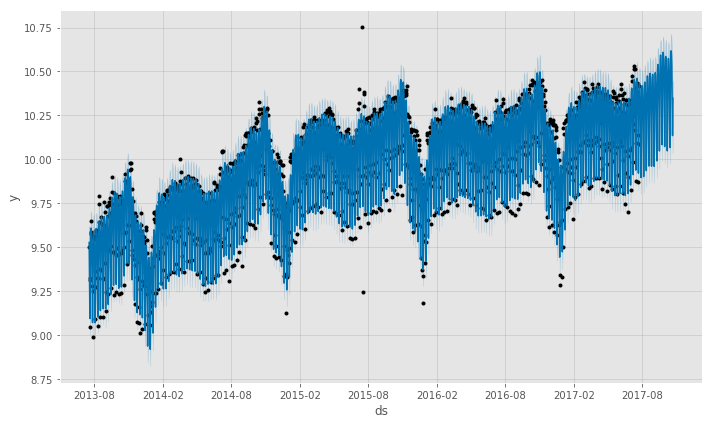

In [14]:
m2 = Prophet()
m2.fit(data)
future2 = m2.make_future_dataframe(periods=90)
forecast2 = m2.predict(future2)
m2.plot(forecast2);

In [29]:
forecast1["Sessions"] = np.exp(forecast1.yhat).round()
forecast1["Sessions_lower"] = np.exp(forecast1.yhat_lower).round()
forecast1["Sessions_upper"] = np.exp(forecast1.yhat_upper).round()
forecast1[(forecast1.ds > "10-01-2017") &
          (forecast1.ds < "11-12-2017")][["ds", "yhat", "Sessions_lower", 
                                        "Sessions", "Sessions_upper"]]
next_year = forecast1[(forecast1.ds > "7-27-2017") &
          (forecast1.ds < "7-25-2018")][["ds", "yhat", "Sessions_lower", 
                                        "Sessions", "Sessions_upper"]]
next_year.max()

ds                2018-07-24 00:00:00
yhat                          10.7107
Sessions_lower                  40625
Sessions                        44835
Sessions_upper                  51182
dtype: object

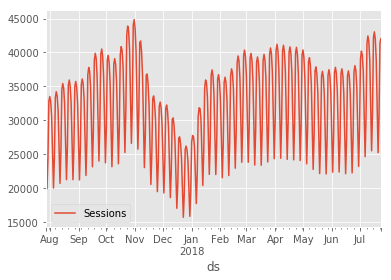

In [37]:
forecast1[(forecast1.ds > "7-27-2017") &
          (forecast1.ds < "7-25-2018")].plot(x="ds", y="Sessions", kind= "line")

In [18]:
#future2 = m2.make_future_dataframe(periods=90)
#forecast2= m2.predict(future2)
forecast2["Sessions"] = np.exp(forecast2.yhat).round()
forecast2["Sessions_lower"] = np.exp(forecast2.yhat_lower).round()
forecast2["Sessions_upper"] = np.exp(forecast2.yhat_upper).round()
forecast2[(forecast2.ds > "7-27-2017") &
          (forecast2.ds < "8-25-2017")][["ds", "yhat", "Sessions_lower", 
                                        "Sessions", "Sessions_upper"]]

,ds,yhat,Sessions_lower,Sessions,Sessions_upper
1471,2017-07-28,10.138124,22942.0,25289.0,27850.0
1472,2017-07-29,9.896387,18067.0,19858.0,21683.0
1473,2017-07-30,10.096691,22133.0,24263.0,26758.0
1474,2017-07-31,10.397882,30010.0,32790.0,35842.0
1475,2017-08-01,10.418750,30240.0,33482.0,36605.0
1476,2017-08-02,10.395286,29822.0,32705.0,35996.0
1477,2017-08-03,10.324648,28063.0,30475.0,33584.0
1478,2017-08-04,10.138354,22907.0,25295.0,27759.0
1479,2017-08-05,9.902067,18235.0,19972.0,22110.0
1480,2017-08-06,10.107745,22309.0,24532.0,26936.0
